In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
from transformer.utils import *
from dataset.dataset_loader import *
import transformer.training as training
import transformer.plot as plot
import pandas as pd
from transformer.preproccessUtils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [4]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [6]:
anchor_examples = pickle.load( open( "results/transformer_anchor_examples.pickle", "rb" ))
explanations = pickle.load(open( "results/gru_extended_counter_exps.pickle", "rb" ))
#explanations = [exp for exp in explanations if len(exp.fit_examples)] 
predictions = pickle.load(open( "results/gru_train_predictions.pickle", "rb" ))

In [7]:
predictions = [p.detach().cpu() for p in predictions]

In [8]:
label_distribution = get_label_distribution(ds_train)
occurences = get_occurences(ds_train)
prediction_dist = get_prediction_distribution(ds_train, predictions)
statistics = [label_distribution, occurences, prediction_dist]

In [9]:
examples = generate_example(ds_train, anchor_examples, explanations)

In [10]:
original_train = ds_train.examples
size = len(examples)
train_size = round(0.75*size)
ds_train.examples = examples[:train_size]
ds_valid.examples = examples[train_size:]
ds_test = ds_valid

# GRU

In [11]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device,output_directory = 'results', task = 'classification'):
    NUM_EPOCHS = 100
    loss_fn = nn.NLLLoss()
    hp = load_hyperparams(model_name, type_dataset)
    if task == 'regression':
        hp['output_classes'] = 1
        loss_fn = nn.MSELoss()
        
    if model_name == 'gru':
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout'], statistics, task == 'regression').to(device)
    elif model_name == 'attention':
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)

    dl_train, dl_valid, dl_test = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=hp['batch_size'], sort = False, shuffle=False, device=device)
 
    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)

    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))
    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    if task == 'classification':
        all_dataloaders = [dl_train, dl_valid, dl_test]
        type_dls = ['train', 'valid', 'test']
        accuracies = []
        for dl, type_dl in zip(all_dataloaders, type_dls):
            y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
            df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
            accuracies.append(accuracy)
            display(df)
        numpy_accuracy = np.array(accuracies)
        df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
        df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

In [ ]:
import os
if os.path.isfile("results/gru.pt"):
    os.remove("results/gru.pt")
SEED = 84
torch.manual_seed(SEED)
training.regression = True
train_model('gru', device, task='regression')

# Bert

In [ ]:
def save_to_csv(examples, name):
    text = [' '.join(example.text) for example in examples]
    label = [example.label for example in examples]
    pd.DataFrame({'review': text, 'label': label}).to_csv(f'dataset/hugging/{name}.csv')

In [ ]:
save_to_csv(train_examples, 'train')
save_to_csv(valid_examples, 'dev')

In [ ]:
from transformer.huggingUtils import *
set_seed()
model = load_model('roberta-base')
data = load_data('dataset/hugging', 'dataset/hugging')
tokenized_data = tokenize_dataset(data, tokenizer_name='roberta-base')
train(model, tokenized_data)

# Statistics

In [13]:
df = pd.DataFrame([e.label for e in original_train],columns = ['label'])
df.label.value_counts()

positive    3557
negative    3443
Name: label, dtype: int64

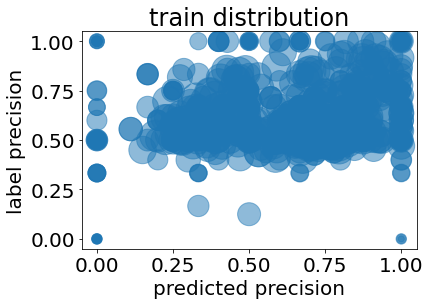

In [14]:
real_precisions = [exp.real_precision for exp in explanations]
test_precisions = [exp.test_precision for exp in explanations]
plt.scatter(test_precisions, real_precisions, s = range(len(explanations)), alpha = 0.5)
plt.title('train distribution')
plt.xlabel('predicted precision')
_ = plt.ylabel('label precision')

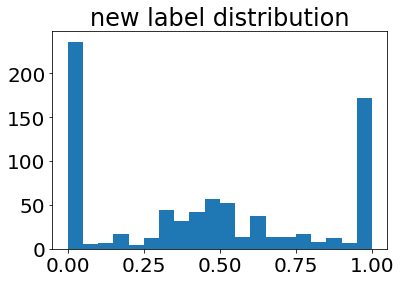

In [15]:
plt.title('new label distribution')
_ = plt.hist([e.label for e in ds_train], bins=20)

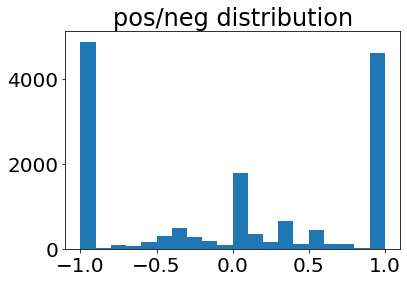

In [16]:
plt.title('pos/neg distribution')
_ = plt.hist(list(label_distribution.values()), bins=20)

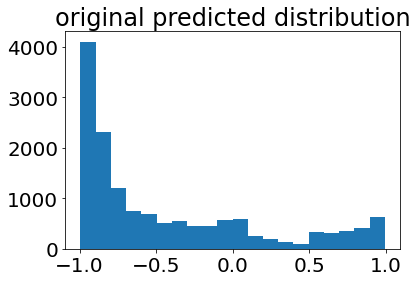

In [29]:
plt.title('original predicted distribution')
prediction_list = [torch.tensor(x).item() for x in prediction_dist.values()]
_ = plt.hist(prediction_list, bins=20)

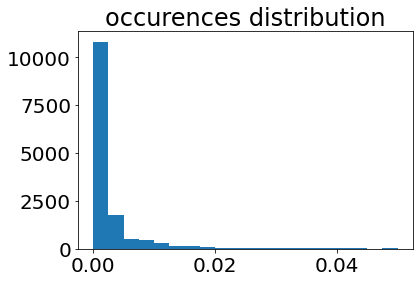

In [17]:
plt.title('occurences distribution')
_ = plt.hist(list(occurences.values()), bins=20, range=(0, 0.05))